# Metrics
In this notebook we will calculate and plot the metrics coming from the YOLO training runs. If you want to analyse the metrics from a run you performed, you can skip the *Load Data* section, place your run data inside a `run_data` directory and continue from the *Setup Data* section.

# Load Data
As a first step, let's fetch the results from our training run.

In [34]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import os

In [35]:
!curl -L https://aml-2023.s3.eu-north-1.amazonaws.com/final-project/yolo_runs_epoch_90.zip > yolo_runs_epoch_90.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20.8M  100 20.8M    0     0  2088k      0  0:00:10  0:00:10 --:--:-- 1123k


And extract into a chosen directory.

In [36]:
import zipfile

run_data_dir = "run_data"
Path(run_data_dir).mkdir(exist_ok=True, parents=True)

with zipfile.ZipFile("yolo_runs_epoch_90.zip", 'r') as zip_ref:
    zip_ref.extractall(run_data_dir)

# Setup Data
Let's load the run dataframe.

In [37]:
run_results = pd.read_csv("run_data/runs/detect/train/results.csv")

Then, let's fetch the training and validation data. This we need for the validation of the YOLO model at the end.

In [38]:
!bash fetch_data.sh --type yolo --output garbage_subset --percentage subset

yolo dataset
Subset dataset
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 27.5M  100 27.5M    0     0   896k      0  0:00:31  0:00:31 --:--:-- 1958k
replace garbage_subset/data.yaml? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
Data downloaded and extracted into garbage_subset


# Extract Train and Validation Results
Then, we extract the training and validation columns from the dataframe.

In [39]:
train_columns = list(filter(lambda col_name: "train" in col_name, run_results.columns))
train_results = run_results[train_columns]

val_columns = list(filter(lambda col_name: "val" in col_name, run_results.columns))
val_results = run_results[val_columns]

Create the output directory for our plots if it doesn't already exist.

In [40]:
Path("metrics_plots").mkdir(exist_ok=True, parents=True)

# Plot
Create a function to plot the loss and save it if requested. We always plot the training and validation loss values for a specific type of loss together, e.g. box loss.

In [41]:
import os

def plot_loss(train, val, name, save=False, save_dir=None, save_format="svg"):
    """Creates a figure, axis tuple for the train and validation losses.

    To save the plot, both the save and save_dir parameters must be set. Images will be saved as svg by default.

    :arg
        train - an iterable of the training loss.
        val - an iterable of the validation loss.
        name - the name of the loss, e.g. box loss. This will be the title of the plot.
        save - whether to save the plot.
        save_dir - the directory where to save the plot, must exist before calling this function.
        save_format - the format to save the plot in, default is svg.

    :return
        fig, ax - the figure and axis object of the plot.
    """
    fig, ax = plt.subplots()

    ax.plot(train, label="Train")
    ax.plot(val, label="Val")
    ax.set_title(name)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.grid(True)
    ax.legend()

    if save and save_dir:
        file_name = f"{name.replace(' ', '_')}.{save_format}"
        fig.savefig(os.path.join(save_dir, file_name), format=save_format)
    return fig, ax

Finally, we call the `plot_loss` method to create and save the loss plots in the specified directory.

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Distributional Focal Loss'}, xlabel='Epoch', ylabel='Loss'>)

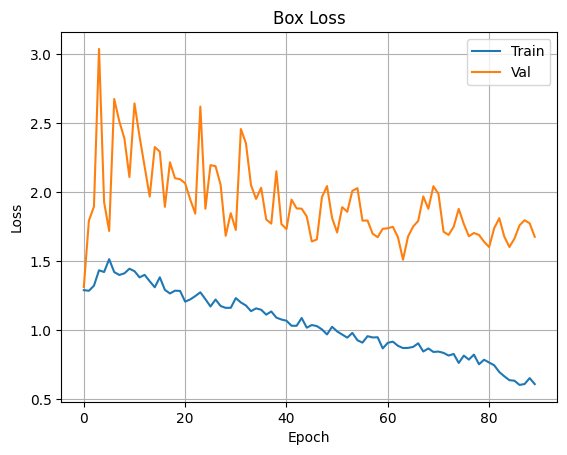

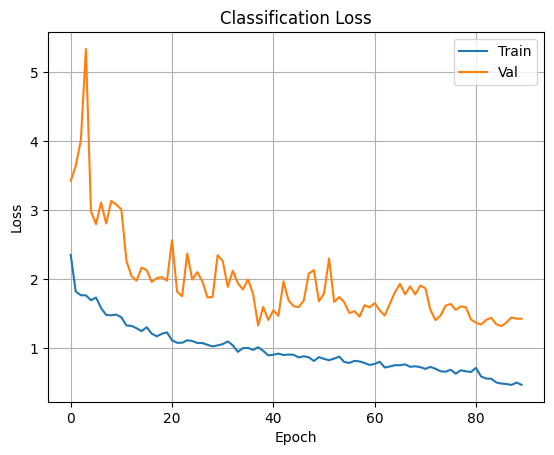

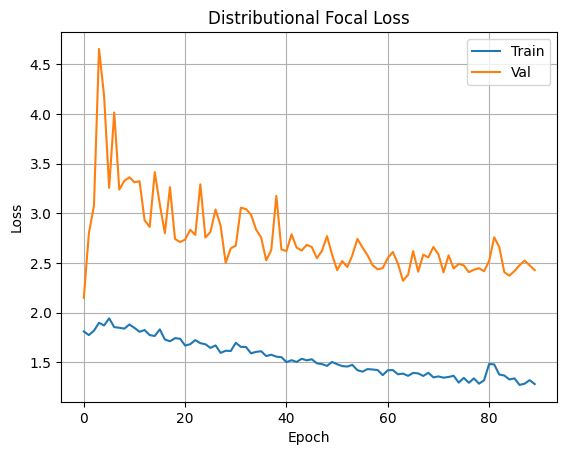

In [43]:
plot_loss(train_results.iloc[:, 0], val_results.iloc[:, 0], "Box Loss", save=True, save_dir="metrics_plots")
plot_loss(train_results.iloc[:, 1], val_results.iloc[:, 1], "Classification Loss", save=True, save_dir="metrics_plots")
plot_loss(train_results.iloc[:, 2], val_results.iloc[:, 2], "Distributional Focal Loss", save=True, save_dir="metrics_plots")

# Classification Metrics
Next, let's do the classification metrics:

* precision
* recall
* precision-recall
* F1

In [44]:
from ultralytics import YOLO
from ultralytics.nn.tasks import DetectionModel
import torch

# Setup Model
As a first step, we need to setup up the model by doing the following:

1. Create a `DetectionModel` with the garbage architecture, basically just use a single class instead of the many that are normally used.
2. Load the best weights from the training into this model.
3. Create the YOLO model with the same best weights and with a detection task, since we want to do object detection here.
4. Assign the detection model to the `model` field of the YOLO object. This is a bit hacky but it's the only way we can let YOLO know that it should only predict a single class.

In [45]:
det = DetectionModel("model.yaml")
det.load(torch.load("run_data/runs/detect/train/weights/best.pt"))
model = YOLO(model="run_data/runs/detect/train/weights/best.pt", task="detect")  # load a pretrained model (recommended for training)
model.model = det


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

# Model Validation
Next, we validate the model on the **test** data by simply calling the `val` method with the path to the `.yaml` file where we specify the dataset. This will return a `Metrics` object from which we can access all the metrics we are interested in.

In [50]:
# Validate the model
data_path = os.path.abspath("garbage_subset/data.yaml")
metrics = model.val(data=data_path)  # no arguments needed, dataset and settings remembered

Ultralytics YOLOv8.0.227 🚀 Python-3.10.13 torch-2.1.1+cu121 CPU (AMD Ryzen 5 7640U w/ Radeon 760M Graphics)


val: Scanning /home/jonasbarth/Desktop/uni/msc/year-2/aml/final-project/final-project/garbage_subset/valid/labels.cache... 30 images, 2 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


                   all         30         29      0.756      0.552      0.664      0.314
Speed: 1.5ms preprocess, 65.1ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to /home/jonasbarth/Desktop/uni/msc/year-2/aml/final-project/final-project/runs/detect/val5


# Inference on Demo Images
Let's run the trained YOLOv8 model on some images to see how it performs. We will also save the images with the predicted bounding boxes.

0: 640x640 2 0s, 1: 640x640 1 0, 2: 640x640 1 0, 3: 640x640 1 0, 4: 640x640 1 0, 5: 640x640 (no detections), 360.7ms
Speed: 1.5ms preprocess, 60.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


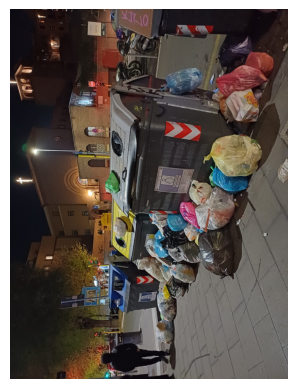

In [60]:
import glob

demo_images = glob.glob("demo_images/*")
preds = model(demo_images, conf=0.4)

bboxes = torch.Tensor([])
confidence = torch.Tensor([])
image_id = []
id = 0

for pred, img in zip(preds, demo_images):
    image_id += [id] * len(pred.boxes.xywh)
    id += 1
    bboxes = torch.cat((bboxes, pred.boxes.xywh))
    confidence = torch.cat((confidence, pred.boxes.conf))
    pred_image = pred.plot()[:, :, ::-1]
    plt.imshow(pred_image)
    plt.axis("off")
    
    image_name = os.path.split(img)[-1]
    save_path = f"pred_{image_name}"
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0.0)

Create a dataframe with the bounding boxes, so that we can plot them together with other models if needed.

In [61]:
bboxes_df = pd.DataFrame(bboxes, columns=["x", "y", "width", "height"])
bboxes_df["image"] = image_id
bboxes_df["confidence"] = confidence

In [63]:
bboxes_df.to_csv("yolo_bboxes.csv")

# Plotting the Metrics
Now, let's plot the metrics. First, let's create a plot function that we can reuse, similar to the `plot_loss` function above.

In [52]:
import numpy as np

def plot_metric(x_data, y_data, xlabel, ylabel, title, save=False, save_dir=None, save_format="svg"):
    """Plots a metric of the YOLOv8 model.

    arg:
        x_data - the data to plot on the x axis. Should just be a single variable (statistically speaking). If none, the range of the y_data will be used to plot.
        y_data - the data to plot on the y axis. Should just be a single variable (statistically speaking).
        xlabel - the label of the x axis.
        ylabel - the label of the y axis.
        title - the title of the plot.
        save - whether to save the plot.
        save_dir - the directory where to save the plot, must exist before calling this function.
        save_format - the format to save the plot in, default is svg.

    :return
        fig, ax - the figure and axis object of the plot.
    """

    fig, ax = plt.subplots()

    if x_data is None:
        ax.plot(range(y_data), y_data)
    else:
        ax.plot(x_data, y_data)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    ax.grid(True)

    if save and save_dir:
        file_name = f"{title.replace(' ', '_')}.{save_format}"
        fig.savefig(os.path.join(save_dir, file_name), format=save_format)
    return fig, ax

# Precision
Precision is a measurement of how many of our predicted true positives are actually true positives:

$$
precision = \frac{TP}{TP + FP}
$$

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Precision-Confidence'}, xlabel='Confidence', ylabel='Precision'>)

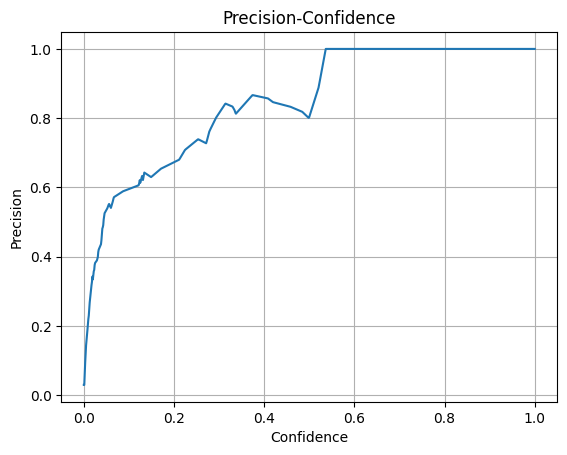

In [53]:
plot_metric(np.linspace(0, 1, len(metrics.box.p_curve.T)), metrics.box.p_curve.T, "Confidence", "Precision", "Precision-Confidence", save=True, save_dir="metrics_plots")

# Recall
Recall is a measure of how many of the positive samples in our dataset we predicted as positive, i.e. out of all the images with garbage in them, how many did we identify as having garbage:

$$
recall = \frac{TP}{TP + FN}
$$

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Recall-Confidence'}, xlabel='Confidence', ylabel='Recall'>)

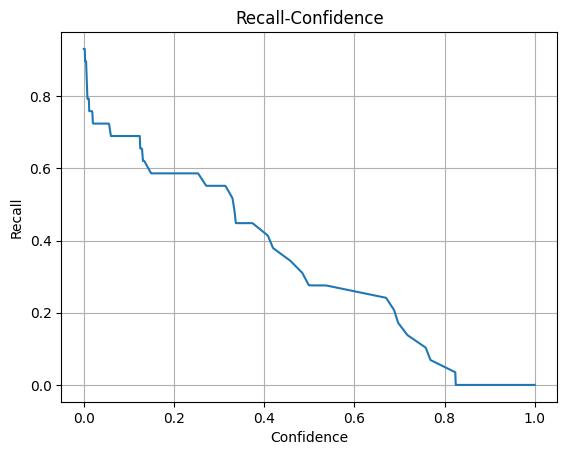

In [54]:
plot_metric(np.linspace(0, 1, len(metrics.box.r_curve.T)), metrics.box.r_curve.T, "Confidence", "Recall", "Recall-Confidence", save=True, save_dir="metrics_plots")

# Precision Recall
The precision-recall is a plot of both the precision and recall curves at different thresholds, allowing us to see a trade off between the two metrics and selecting a prediciton threshold for the model that balances the two.

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Precision-Recall'}, xlabel='Precision', ylabel='Recall'>)

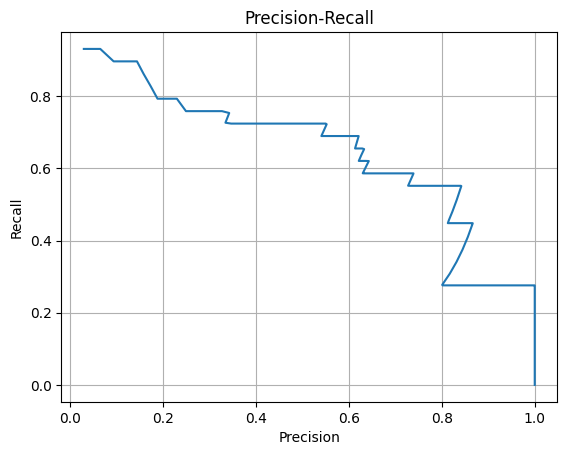

In [55]:
plot_metric(metrics.box.p_curve.T, metrics.box.r_curve.T, "Precision", "Recall", "Precision-Recall", save=True, save_dir="metrics_plots")

# F1
The F1 score unifies precision and recall into a single score by taking the harmonic mean between the two:

$$
F1 = \frac{TP}{TP + \frac{1}{2}(FP + FN)}
$$

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'F1-Confidence'}, xlabel='Confidence', ylabel='F1'>)

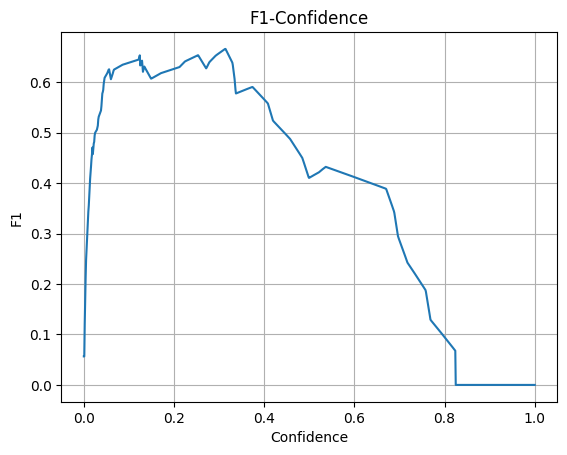

In [57]:
plot_metric(np.linspace(0, 1, len(metrics.box.f1_curve.T)), metrics.box.f1_curve.T, "Confidence", "F1", "F1-Confidence", save=True, save_dir="metrics_plots")